# Subject

**a. Task**

In this project, you will try to analyze photos of fried eggs made in a restaurant to make a judgement whether these fried eggs are good enough to be served or not. There can be different problems in the cooking process: too few yolks, too many of them, some of them might be broken, it can be overcooked.

Here are the tasks that you need to do:
1. data labeling with instance segmentation,
2. data preprocessing,
3. fried eggs classification.


**b. Dataset**

You will work with the dataset of fried eggs. It contains 199 unlabeled images of fried eggs (train) and 65 images from the hidden test sample for which we know classes.

The classes are the following:
- 0 – good fried eggs (three yolks, parsley in the center, well-cooked, looks like a whole and not several separate pieces),
- 1 – overcooked or overturned fried eggs,
- 2 – fried eggs with two yolks,
- 3 – fried eggs with a broken yolk,
- 4 – fried eggs with four yolks,
- 5 – fried eggs with a wrong position of ingredients or they are missing, wrong placement or composition, undercooked.


**c. Implementation**

Data Labeling
1. You need to label the images from the train sample using 6 classes described above.
2. In order to solve the project with a good quality you will have to solve the instance segmentation task. To make it happen you need to annotate your images with in- stances of different objects: to show where on the image you have a piece of bacon, yolk or a piece of parsley. Inference annotations as masks to polygons (XMLs)
3. To automate this process use the active learning approach by training a neural net that will learn from you which objects are on the image.

Data Preprocessing
1. Resize images to 1024x768.
2. You need to learn to crop images: only a plate with fried eggs should go to a CNN.
3. Extract masks of the ingredients. Use them as an input to CNN.

Classification
1. Use raw images, masks, the number of different ingredients as input for a CNN.
2. Try different approaches and algorithms. You will need to achieve logloss on the test dataset at most – 9.56.


**d. Submission**

Your repository should contain one or several notebooks with your solutions and vi- sualizations. It should contain a CSV file with the list of filenames and corresponding classes. You can download the template from here.


**Bonus part**

1. Work with data augmentation.
2. Achieve a better logloss – 2.66.

# Colab setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !nvidia-smi -L

# Imports

In [3]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import cv2
import tensorflow as tf
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from google.colab import widgets
from IPython.display import clear_output

import random
import shutil
import pathlib

print(tf.__version__)

2.9.2


# Variables

In [4]:
np.random.seed(21)
random.seed(21)
PATH = '/content/drive/MyDrive/Colab Notebooks/21/friedeggs/'
# PATH = ''

# Load data

In [5]:
!ls '/content/drive/MyDrive/Colab Notebooks/21/friedeggs/data'

fried_eggs.csv	test  train  work


In [6]:
data_dir = pathlib.Path(PATH+'data')
images_num = 0
for folder in ['train', 'test']:
    folder_num = len(list(data_dir.glob('{}/*'.format(folder))))
    images_num += folder_num
    print('{}: {}'.format(folder, folder_num))
print('\nTotal number of images: {}'.format(images_num))

train: 199
test: 65

Total number of images: 264


Change path for label

In [7]:
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/21/friedeggs/data/work/train/1/unlabeled")
print('Total number of label_0 images on Google Drive: {}'.format(len(list(data_dir.glob('*')))))

Total number of label_0 images on Google Drive: 199


In [8]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/21/friedeggs/data/work/train/1"

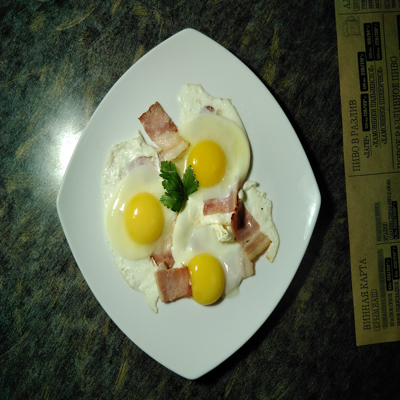

In [9]:
image_example_name = 'IMG_20180213_172433.jpg'
im = PIL.Image.open(os.path.join(DATA_DIR, 'unlabeled', image_example_name))
display(im.resize((400,400)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

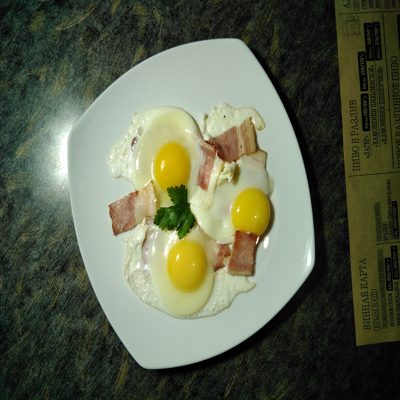

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

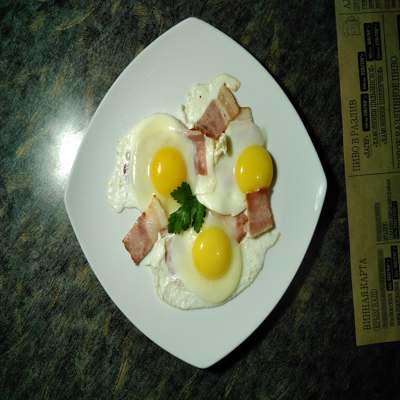

<IPython.core.display.Javascript object>

In [10]:
im_0 = PIL.Image.open(os.path.join(DATA_DIR, 'unlabeled', 'IMG_20180213_172438.jpg'))
im_1 = PIL.Image.open(os.path.join(DATA_DIR, 'unlabeled', 'IMG_20180213_172441.jpg'))
grid = widgets.Grid(1, 2, header_row=False, header_column=False)
with grid.output_to(0, 0):
  display(im_0.resize((400,400)))
with grid.output_to(0, 1):
  display(im_1.resize((400,400)))

In [11]:
def move_files_by_names(file_names, src_folder, dest_folder, clear_dest_dir_if_exist=True, copy_src=False):
  if not clear_dest_dir_if_exist:
    os.makedirs(dest_folder, exist_ok=True)
  else:
    try:
      os.makedirs(dest_folder, exist_ok=False)
    except IOError or FileExistsError as io_err:
      shutil.rmtree(dest_folder, ignore_errors=True)
      os.makedirs(dest_folder, exist_ok=False)
  for file_name in file_names:
    if copy_src == False:
      shutil.move(os.path.join(src_folder, file_name), dest_folder)
    else:
      shutil.copy(os.path.join(src_folder, file_name), dest_folder)

In [12]:
TEST_SHARE = 0.3
LABELED_NUM = 15 #140


all_files_names = os.listdir(os.path.join(DATA_DIR, 'unlabeled'))
dataset_size = len(all_files_names)

test_files_names = random.sample(all_files_names, int(TEST_SHARE*len(all_files_names)))
move_files_by_names(file_names=test_files_names, src_folder=os.path.join(DATA_DIR, 'unlabeled'), dest_folder=os.path.join(DATA_DIR, 'test'))

all_files_names = os.listdir(os.path.join(DATA_DIR, 'unlabeled'))
labeled_files_names = random.sample(all_files_names, LABELED_NUM)
move_files_by_names(file_names=labeled_files_names, src_folder=os.path.join(DATA_DIR, 'unlabeled'), dest_folder=os.path.join(DATA_DIR, 'labeled'))

assert dataset_size == len(os.listdir(os.path.join(DATA_DIR, 'unlabeled'))) + \
len(os.listdir(os.path.join(DATA_DIR, 'test'))) + len(os.listdir(os.path.join(DATA_DIR, 'labeled')))

In [13]:
print("{} images for initial labeling\n{} images for model testing\n{} unlabeled images".format(LABELED_NUM, 
                                                                                                len(os.listdir(os.path.join(DATA_DIR, 'test'))), 
                                                                                                len(os.listdir(os.path.join(DATA_DIR, 'unlabeled')))))

15 images for initial labeling
59 images for model testing
125 unlabeled images


Data Labeling
1. You need to label the images from the train sample using 6 classes described above.
2. In order to solve the project with a good quality you will have to solve the instance segmentation task. To make it happen you need to annotate your images with in- stances of different objects: to show where on the image you have a piece of bacon, yolk or a piece of parsley. Inference annotations as masks to polygons (XMLs)
3. To automate this process use the active learning approach by training a neural net that will learn from you which objects are on the image.

Маркировка данных
1. Вам нужно пометить изображения из примера поезда, используя 6 классов, описанных выше.
2. Для качественного решения проекта необходимо решить задачу сегментации экземпляра. Для этого вам нужно аннотировать свои изображения экземплярами различных объектов: показать, где на изображении у вас есть кусок сала, желток или кусочек петрушки. Аннотации логического вывода как маски полигонов (XML)
3. Чтобы автоматизировать этот процесс, используйте подход активного обучения, обучив нейронную сеть, которая будет узнавать от вас, какие объекты находятся на изображении.

In [14]:
def label_images(images_dir, max_images_num=None):
  file_names = os.listdir(images_dir)
  i = 0
  if max_images_num == None:
    max_num = len(file_names)
  else:
    max_num = max_images_num
  labels = []

  print('Starting labeling from {}th image\n'.format(i))
  while i < max_num:
    image_id = file_names[i]
    im = PIL.Image.open(os.path.join(images_dir, image_id))
    print("Image {} out of {}\n".format(i+1, max_num))
    print("Is this label?")
    print("0 - No\n1 - Yes")
    grid = widgets.Grid(2, 2, header_row=True, header_column=True)
    with grid.output_to(1, 1):
      display(im.resize((400,400)))
      new_im = im.resize((768,1024))
      new_im.save(os.path.join(images_dir, image_id))
    with grid.output_to(0, 0):
      userinput = input()
    clear_output(wait=True)
    
    i += 1
    if userinput not in ('0', '1'):
      print('Incorrect input. Please try again')
      time.sleep(3)
      clear_output()
      i -= 1
    else:
      if userinput == '1': labels.append(image_id)

  return list(set(labels)), i

- 0 – good fried eggs (three yolks, parsley in the center, well-cooked, looks like a whole and not several separate pieces),
- 1 – overcooked or overturned fried eggs,
- 2 – fried eggs with two yolks,
- 3 – fried eggs with a broken yolk,
- 4 – fried eggs with four yolks,
- 5 – fried eggs with a wrong position of ingredients or they are missing, wrong placement or composition, undercooked.

Image 15 out of 15

Is this label?
0 - No
1 - Yes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

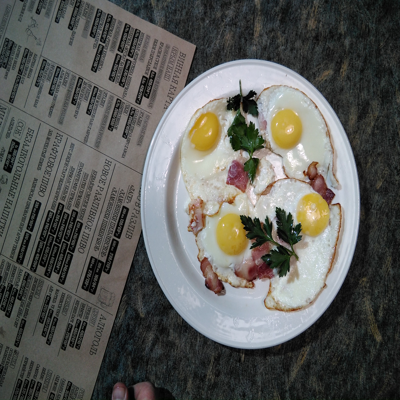

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0


<IPython.core.display.Javascript object>

In [15]:
labeled_dir = os.path.join(DATA_DIR, 'labeled')
good_images, i = label_images(images_dir=labeled_dir)

In [16]:
# store good images in a separate folder 'labeled/good'
l = len(os.listdir(os.path.join(DATA_DIR, 'labeled')))
move_files_by_names(file_names=good_images, src_folder=os.path.join(DATA_DIR, 'labeled'), dest_folder=os.path.join(DATA_DIR, 'labeled/good'))

In [17]:
# store bad images in a separate folder 'labeled/bad'
bad_images = list(os.walk(os.path.join(DATA_DIR, 'labeled')))[0][2]
move_files_by_names(file_names=bad_images, src_folder=os.path.join(DATA_DIR, 'labeled'), dest_folder=os.path.join(DATA_DIR, 'labeled/bad'))
assert l == len(os.listdir(os.path.join(DATA_DIR, 'labeled', 'good'))) + len(os.listdir(os.path.join(DATA_DIR, 'labeled', 'bad')))

In [18]:
GOOD_IMAGE_SHARE = len(good_images) / l
print("{0} good images out of {1} images ({2:.0f}%)".format(len(good_images), l, 100 * GOOD_IMAGE_SHARE))

6 good images out of 15 images (40%)


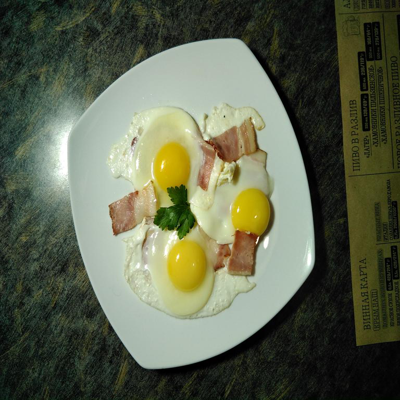

In [19]:
im = PIL.Image.open(os.path.join(DATA_DIR, 'labeled', 'bad', bad_images[0]))
display(im.resize((400,400)))

In [20]:
import math
import seaborn as sns

def check_filtering(model, from_directory=True, img_path=None, img_dataset=None, sample_size=50, use_uncertainty_measure=False, return_img_names=False):

  # create a dataset from directory if from_directory=True
  print('Preparing dataset for prediction')
  if from_directory:
    if not img_path:
      img_directory = os.path.join(DATA_DIR, 'test')
    else:
      img_directory = img_path
    test_images = tf.keras.utils.image_dataset_from_directory(img_directory, labels=None, shuffle=False, )
  else:
    test_images = img_dataset

  # get model predictions
  print('Generating predictions')
  predictions = model.predict(test_images)

  # collect top-sample_size images with the highest score or uncertainty measure
  print('Selecting images for labeling')
  pred_df = pd.DataFrame({'predict_proba': predictions.flatten(), 'file_path': test_images.file_paths})
  if use_uncertainty_measure:
    sorting_col = 'uncertainty'
    pred_df['uncertainty'] = pred_df['predict_proba'].apply(lambda x: (x-1) * math.log(1-x) - x * math.log(x))
  else:
    sorting_col = 'predict_proba'
  
  pred_df.sort_values(sorting_col, ascending=False, inplace=True)
  pred_df = pred_df.head(sample_size)
  pred_df['file_path'] = pred_df['file_path'].apply(lambda x: str(os.path.basename(x)))
  imgs_for_labeling = pred_df['file_path'].values
  l = len(os.listdir(img_directory))
  move_files_by_names(file_names=imgs_for_labeling, src_folder=img_directory, 
                      dest_folder=os.path.join(DATA_DIR, 'temp_check'), clear_dest_dir_if_exist=True, copy_src=True)
  assert len(os.listdir(img_directory)) == l
  assert len(os.listdir(os.path.join(DATA_DIR, 'temp_check'))) == sample_size

  # ask user to label the images
  first_class_images, i = label_images(images_dir=os.path.join(DATA_DIR, 'temp_check'))

  # save information on manual labeling
  first_class_df = pd.DataFrame({'file_path': first_class_images})
  first_class_df['class_1'] = True
  pred_df = pd.merge(pred_df, first_class_df, how='left', on='file_path')
  pred_df['class_1'].fillna(False, inplace=True)

  # show sample statistics
  print('Generated predictions for {} images'.format(len(predictions)))
  plt.title('Predicted probability histogram')
  plt.xlabel('1-class predicted probability')
  sns.histplot(predictions)
  plt.show()
  first_class_share = len(first_class_images) / sample_size
  if use_uncertainty_measure:
    print('\nLabeled images with the highest uncertainty measure:')
  else:
    print('\nLabeled images with the highest first class probability:')
  print('\t{} images labeled'.format(sample_size))
  print('\t{0} ({1:.0f}%) of images of the first class in top-{2} sample:'.format(
      len(first_class_images), 100 * first_class_share, sample_size))

  if return_img_names:
    return pred_df, first_class_images
  else:
    return pred_df

In [21]:
dummy_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1), 
  tf.keras.layers.Activation('sigmoid')
])

dummy_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Generated predictions for 59 images


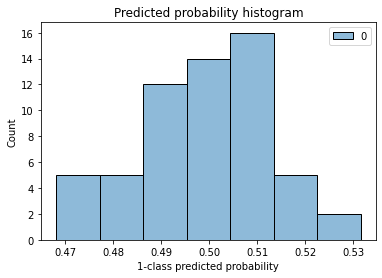


Labeled images with the highest first class probability:
	15 images labeled
	8 (53%) of images of the first class in top-15 sample:


In [22]:
good_images_dummy = check_filtering(model=dummy_model, sample_size=15) #50

Data Preprocessing
1. Resize images to 1024x768.
2. You need to learn to crop images: only a plate with fried eggs should go to a CNN.
3. Extract masks of the ingredients. Use them as an input to CNN.

Предварительная обработка данных
1. Измените размер изображений до 1024x768.
2. Нужно научиться кадрировать изображения: только тарелка с яичницей должна идти на CNN.
3. Экстрактные маски из ингредиентов. Используйте их в качестве входных данных для CNN.

Original Dimensions : (1024, 768, 3)
Resized Dimensions : (1024, 768, 3)


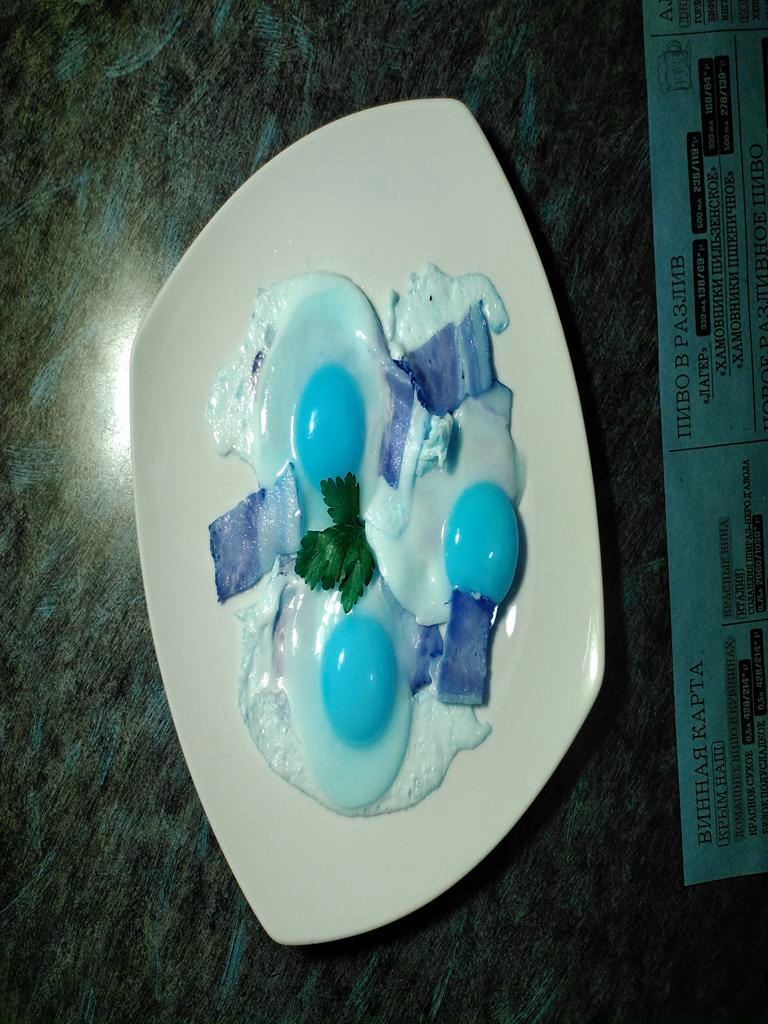

In [23]:
img = cv2.imread(os.path.join(DATA_DIR, 'labeled', 'bad', bad_images[0]))

# Get original height and width
print(f"Original Dimensions : {img.shape}")

# resize image by specifying custom width and height
resized = cv2.resize(img, (768, 1024))

print(f"Resized Dimensions : {resized.shape}")
display(PIL.Image.fromarray(resized))
# cv2.imwrite(os.path.join(DATA_DIR, 'labeled', 'good', good_images[0]), resized)

**Resize**

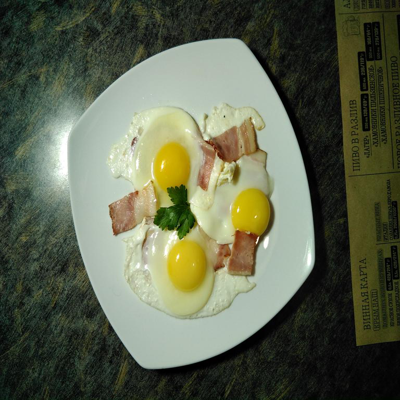

In [24]:
im = PIL.Image.open(os.path.join(DATA_DIR, 'labeled', 'bad', bad_images[0]))
display(im.resize((400,400)))

**Scope**

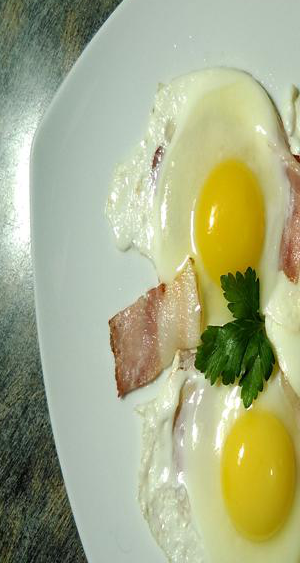

In [25]:
im = PIL.Image.open(os.path.join(DATA_DIR, 'labeled', 'bad', bad_images[0]))
width, height = im.size
left = 100
top = height / 5
right = 400
bottom = 3 * height / 4
im1 = im.crop((left, top, right, bottom))
display(im1)

**Augmentation**

In [26]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

In [27]:
image = np.array(im)
transformed = transform(image=image)
transformed_image = transformed["image"]
new_image = PIL.Image.fromarray(transformed_image)

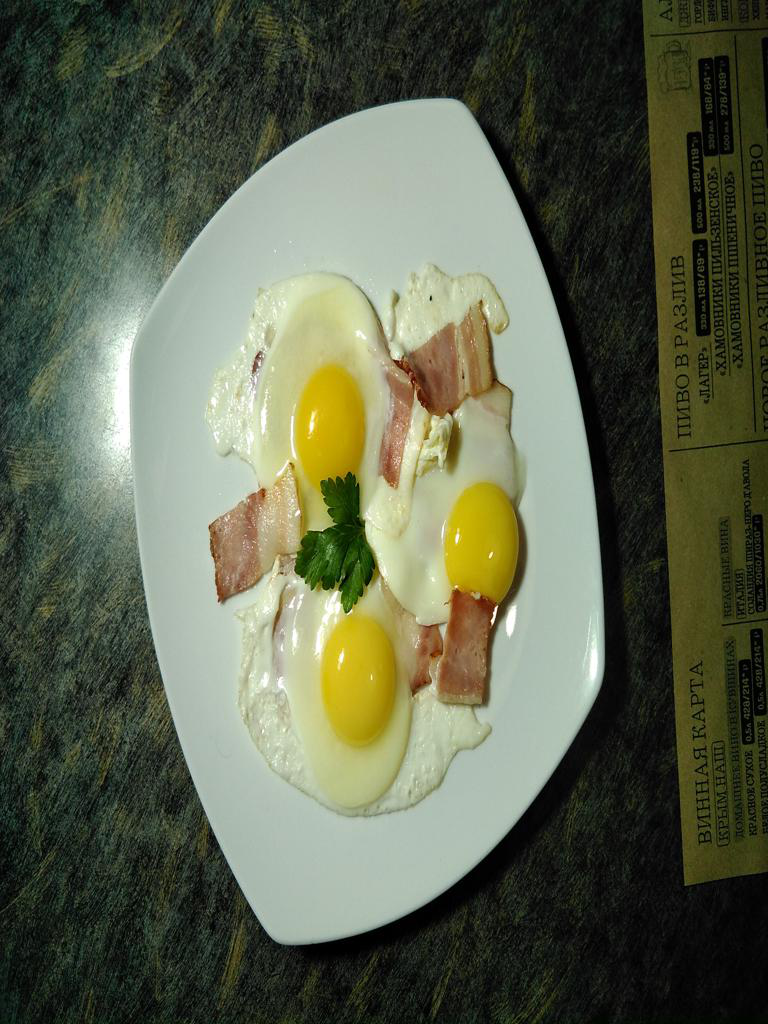

In [28]:
display(new_image)

Classification
1. Use raw images, masks, the number of different ingredients as input for a CNN.
2. Try different approaches and algorithms. You will need to achieve logloss on the test dataset at most – 9.56.

Классификация
1. Используйте необработанные изображения, маски, количество различных ингредиентов в качестве входных данных для CNN.
2. Пробуйте разные подходы и алгоритмы. Вам нужно будет добиться максимального логарифма на тестовом наборе данных — 9,56.

In [29]:
IMAGE_SHAPE = (224, 224)
batch_size = 32

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(DATA_DIR, 'labeled'),
  label_mode='binary',
  class_names=['bad', 'good'],
  validation_split=None,
  batch_size=batch_size
)

Found 15 files belonging to 2 classes.


In [31]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
import tensorflow_hub as hub

# take a "headless" CNN from tensorflow_hub
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [33]:
# convert this model into an untrainable layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=IMAGE_SHAPE+(3,),
    trainable=False)

In [34]:
# add a layer suitable for binary classification and layers for image preprocessing - resizing and rescaling
model = tf.keras.Sequential([
                             tf.keras.layers.Resizing(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1]),
                             tf.keras.layers.Rescaling(1./255),
                             feature_extractor_layer,
                             tf.keras.layers.Dense(1)
])

In [35]:
# define optimization, loss and quality metrics for the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.keras.metrics.BinaryAccuracy())

In [36]:
# train the model on our dataset
NUM_EPOCHS = 30

history = model.fit(train_ds, epochs=NUM_EPOCHS)

Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 1.0290 - binary_accuracy: 0.6000
Epoch 2/30
1/1 [==============================] - 1s 578ms/step - loss: 0.9158 - binary_accuracy: 0.6000
Epoch 3/30
1/1 [==============================] - 1s 552ms/step - loss: 0.8386 - binary_accuracy: 0.6000
Epoch 4/30
1/1 [==============================] - 1s 567ms/step - loss: 0.7918 - binary_accuracy: 0.5333
Epoch 5/30
1/1 [==============================] - 1s 558ms/step - loss: 0.7607 - binary_accuracy: 0.5333
Epoch 6/30
1/1 [==============================] - 1s 554ms/step - loss: 0.7321 - binary_accuracy: 0.6000
Epoch 7/30
1/1 [==============================] - 1s 563ms/step - loss: 0.6993 - binary_accuracy: 0.6000
Epoch 8/30
1/1 [==============================] - 1s 562ms/step - loss: 0.6616 - binary_accuracy: 0.6000
Epoch 9/30
1/1 [==============================] - 1s 595ms/step - loss: 0.6209 - binary_accuracy: 0.6000
Epoch 10/30
1/1 [==============================] - 1s 617m

In [37]:
# add a layer to provide probability of the first class instead of logits
transfer_model = tf.keras.Sequential([model, tf.keras.layers.Activation('sigmoid')])

Generated predictions for 59 images


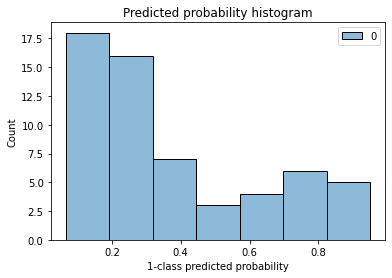


Labeled images with the highest first class probability:
	15 images labeled
	15 (100%) of images of the first class in top-15 sample:


In [38]:
# evaluate the model ability to find objects of the required small class
good_images_transfer = check_filtering(model=transfer_model, sample_size=15) #50

In [39]:
good_images_transfer.head()

predict_proba                file_path  class_1
0       0.950587  IMG_20180213_173043.jpg     True
1       0.930320  IMG_20180213_173716.jpg     True
2       0.885036  IMG_20180213_173650.jpg     True
3       0.852526  IMG_20180213_174635.jpg     True
4       0.829283  IMG_20180213_173833.jpg     True

Generated predictions for 125 images


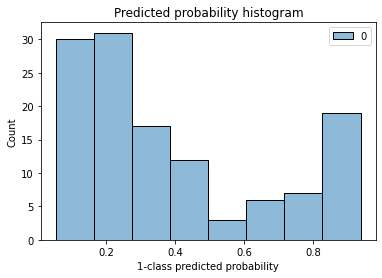


Labeled images with the highest uncertainty measure:
	15 images labeled
	11 (73%) of images of the first class in top-15 sample:


In [40]:
# apply the model on unlabeled dataset and label top-100 images manually
new_good_df, new_good_images = check_filtering(model=transfer_model, from_directory=True, 
                                                     img_path=os.path.join(DATA_DIR, 'unlabeled'), return_img_names=True, sample_size=15, #100
                                                     use_uncertainty_measure=True)

In [41]:
# move 100 newly labeled images to the training folder
move_files_by_names(file_names=new_good_images, src_folder=os.path.join(DATA_DIR, 'unlabeled'), 
                    dest_folder=os.path.join(DATA_DIR, 'labeled', 'good'), clear_dest_dir_if_exist=False, copy_src=False)
new_bad_images = set(os.listdir(os.path.join(DATA_DIR, 'temp_check'))) - set(new_good_images)
move_files_by_names(file_names=new_bad_images, src_folder=os.path.join(DATA_DIR, 'unlabeled'), 
                    dest_folder=os.path.join(DATA_DIR, 'labeled', 'bad'), clear_dest_dir_if_exist=False, copy_src=False)

In [42]:
# prepare training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(DATA_DIR, 'labeled'),
  label_mode='binary',
  class_names=['bad', 'good'],
  validation_split=None,
  batch_size=batch_size
)

Found 30 files belonging to 2 classes.


In [43]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
# create and compile the model 
model = tf.keras.Sequential([
                             tf.keras.layers.Resizing(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1]),
                             tf.keras.layers.Rescaling(1./255),
                             feature_extractor_layer,
                             tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.keras.metrics.BinaryAccuracy())

In [45]:
# train the model
NUM_EPOCHS = 30

history = model.fit(train_ds, epochs=NUM_EPOCHS)

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.7482 - binary_accuracy: 0.4333
Epoch 2/30
1/1 [==============================] - 1s 962ms/step - loss: 0.6921 - binary_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 1s 889ms/step - loss: 0.6714 - binary_accuracy: 0.6667
Epoch 4/30
1/1 [==============================] - 1s 870ms/step - loss: 0.6538 - binary_accuracy: 0.7000
Epoch 5/30
1/1 [==============================] - 1s 981ms/step - loss: 0.6295 - binary_accuracy: 0.7333
Epoch 6/30
1/1 [==============================] - 1s 929ms/step - loss: 0.6008 - binary_accuracy: 0.7667
Epoch 7/30
1/1 [==============================] - 1s 891ms/step - loss: 0.5723 - binary_accuracy: 0.7333
Epoch 8/30
1/1 [==============================] - 1s 966ms/step - loss: 0.5472 - binary_accuracy: 0.7000
Epoch 9/30
1/1 [==============================] - 1s 893ms/step - loss: 0.5260 - binary_accuracy: 0.7000
Epoch 10/30
1/1 [==============================] - 1s 887m

In [46]:
# add a layer to provide probability of the first class instead of logits
new_transfer_model = tf.keras.Sequential([model, tf.keras.layers.Activation('sigmoid')])

Generated predictions for 59 images


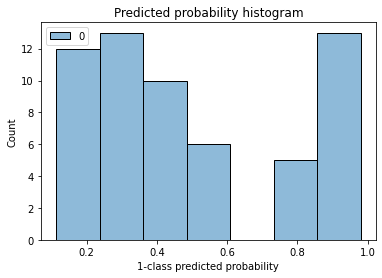


Labeled images with the highest first class probability:
	15 images labeled
	13 (87%) of images of the first class in top-15 sample:


In [47]:
# evaluate the model ability to find objects of the required small class
new_good_images_share_transfer = check_filtering(model=new_transfer_model, sample_size=15) #50

In [48]:
final_good_images_share = new_good_images_share_transfer['class_1'].mean()
random_good_images_share = good_images_dummy['class_1'].mean()
print("Share of images of this label in top-50 sample:\n")
print("\t with the model = {0:.0f}%".format(100 * final_good_images_share))
print("\t with random sampling = {0:.0f}%\n".format(100 * random_good_images_share))

Share of images of this label in top-50 sample:

	 with the model = 87%
	 with random sampling = 53%



In [49]:
# labeled data used for training
manually_labeled_num = len(os.listdir(os.path.join(DATA_DIR, 'labeled/good'))) + len(os.listdir(os.path.join(DATA_DIR, 'labeled/bad')))

# images with insects in labeled data
labeled_good_num = len(os.listdir(os.path.join(DATA_DIR, 'labeled', 'good')))

print("{} images labeled manually for model training".format(manually_labeled_num))
print("{} good images found\n".format(labeled_good_num))

30 images labeled manually for model training
17 good images found



Save submission

In [50]:
TEST_DIR = "/content/drive/MyDrive/Colab Notebooks/21/friedeggs/data/test/"

In [51]:
test_ds = tf.keras.utils.image_dataset_from_directory(TEST_DIR, labels=None, shuffle=False, )

Found 65 files belonging to 1 classes.


In [52]:
predict_proba = transfer_model.predict(test_ds)

3/3 [==============================] - 22s 5s/step


In [53]:
predict_proba

array([[0.12916051],
       [0.11271442],
       [0.2765003 ],
       [0.10252954],
       [0.22003654],
       [0.6030968 ],
       [0.45263782],
       [0.3014848 ],
       [0.22773463],
       [0.15141338],
       [0.37375984],
       [0.31485805],
       [0.22245938],
       [0.1329178 ],
       [0.75867534],
       [0.4826977 ],
       [0.71093553],
       [0.709735  ],
       [0.9564959 ],
       [0.9386032 ],
       [0.72603726],
       [0.60670364],
       [0.7588901 ],
       [0.70581293],
       [0.55851424],
       [0.9454196 ],
       [0.6056697 ],
       [0.6946297 ],
       [0.86795324],
       [0.6230964 ],
       [0.53181094],
       [0.6616489 ],
       [0.60453033],
       [0.48070776],
       [0.24803138],
       [0.29694533],
       [0.15984687],
       [0.16623788],
       [0.18760471],
       [0.08536168],
       [0.18525667],
       [0.22871032],
       [0.09896884],
       [0.12492922],
       [0.16526109],
       [0.16519661],
       [0.39415374],
       [0.169

In [54]:
sub = pd.read_csv(PATH+'data/fried_eggs.csv')
sub.head(20)

img         0   1   2   3   4   5
0   IMG_20180213_172431.jpg  0.021378 NaN NaN NaN NaN NaN
1   IMG_20180213_172436.jpg  0.038645 NaN NaN NaN NaN NaN
2   IMG_20180213_172456.jpg  0.036293 NaN NaN NaN NaN NaN
3   IMG_20180213_172615.jpg  0.020455 NaN NaN NaN NaN NaN
4   IMG_20180213_172618.jpg  0.046697 NaN NaN NaN NaN NaN
5   IMG_20180213_172651.jpg  0.042086 NaN NaN NaN NaN NaN
6   IMG_20180213_172722.jpg  0.041540 NaN NaN NaN NaN NaN
7   IMG_20180213_172726.jpg  0.027369 NaN NaN NaN NaN NaN
8   IMG_20180213_172736.jpg  0.031110 NaN NaN NaN NaN NaN
9   IMG_20180213_172739.jpg  0.019093 NaN NaN NaN NaN NaN
10  IMG_20180213_172902.jpg  0.020727 NaN NaN NaN NaN NaN
11  IMG_20180213_172911.jpg  0.012978 NaN NaN NaN NaN NaN
12  IMG_20180213_172913.jpg  0.011683 NaN NaN NaN NaN NaN
13  IMG_20180213_172921.jpg  0.027879 NaN NaN NaN NaN NaN
14  IMG_20180213_172943.jpg  0.026922 NaN NaN NaN NaN NaN
15  IMG_20180213_172950.jpg  0.014520 NaN NaN NaN NaN NaN
16  IMG_20180213_173004.jpg  0.006785 NaN NaN NaN NaN NaN
17  IMG_20180213_173018.jpg  0.004398 NaN NaN NaN NaN NaN
18  IMG_20180213_173040.jpg  0.001405 NaN NaN NaN NaN NaN
19  IMG_20180213_173056.jpg  0.001093 NaN NaN NaN NaN NaN

In [55]:
sub['img'] = sorted(sub['img'])
sub.head()

img         0   1   2   3   4   5
0  IMG_20180213_172431.jpg  0.021378 NaN NaN NaN NaN NaN
1  IMG_20180213_172436.jpg  0.038645 NaN NaN NaN NaN NaN
2  IMG_20180213_172456.jpg  0.036293 NaN NaN NaN NaN NaN
3  IMG_20180213_172615.jpg  0.020455 NaN NaN NaN NaN NaN
4  IMG_20180213_172618.jpg  0.046697 NaN NaN NaN NaN NaN

In [56]:
sub['1'] = predict_proba
sub.head()

img         0         1   2   3   4   5
0  IMG_20180213_172431.jpg  0.021378  0.129161 NaN NaN NaN NaN
1  IMG_20180213_172436.jpg  0.038645  0.112714 NaN NaN NaN NaN
2  IMG_20180213_172456.jpg  0.036293  0.276500 NaN NaN NaN NaN
3  IMG_20180213_172615.jpg  0.020455  0.102530 NaN NaN NaN NaN
4  IMG_20180213_172618.jpg  0.046697  0.220037 NaN NaN NaN NaN

In [58]:
# sub.to_csv(PATH+'data/fried_eggs.csv', index=False)